# Dataset Construction

In [1]:
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]


# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [2]:
Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html
class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [3]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope, sparsify_threshold):
        self.sparsify_threshold = sparsify_threshold
        self._read_csv(corr_name, corr_scope)

    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{corr_name}/global_corr.csv', delimiter=',')

    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]
        
        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi
        
        df = pd.read_csv('s&p500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]
        
        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        def helper(corr_index):
            if self.sparsify_threshold is None:
                return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())
            else:
                w = self._correlation_matrices[0].copy()
                w[w <= self.sparsify_threshold] = 0
                return np.array(w.nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            if self.sparsify_threshold is not None:
                if len(w.shape) > 2:
                    raise ValueError('Sparsificiation is not supported for multidimensional edge weights')
                else:
                    return w[w > self.sparsify_threshold]
            else:
                # Flatten the first two dimensions
                return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        """Returning the data iterator.
        """
        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [4]:
def get_dataset(corr_name, corr_scope, sparsify_threshold=None):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope, sparsify_threshold=sparsify_threshold)

    lag_size = 64
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [5]:
import math
import torch
import torch.nn.functional as F
from torch import nn


class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads
        
        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5
        
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)
    
    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        if attn_mask is not None:
            attn_weights += attn_mask
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]
        
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        return (attn, attn_weights)


In [6]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x


class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T = 128, N=472):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
    
    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        x = x.reshape(T, N, D)
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.view(T, N, self.d_model)

        for i in range(self.num_layers):
            x = x.view(N, T, self.d_model)
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            x = x.view(T, N, self.d_model)
            A = to_dense_adj(edge_index, edge_attr=edge_weight)
            # Encountered more than one adjacency matrices, e.g. dual correlations
            if len(A.size()) == 4:
                A = A.reshape(A.size(-1), A.size(1), A.size(2))
            x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
            x = x.view(N, T, self.d_model)

        return x

# DCRNN Baseline (adapted from timothewt/SP100AnalysisWithGNNs)

In [7]:
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(nn.Module):
    """
    Simple two layers GCN model.
    """
    def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
        super(GCN, self).__init__()
        layer_sizes = layer_sizes or [32, 32]
        self.convs = nn.ModuleList([
            GCNConv(in_channels, layer_sizes[0], bias=bias),
        ] + [
            GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias) for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the GCN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb) 
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
        """
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_weight))
        return x

class GAT(nn.Module):
    """
    Simple two layers GCN model.
    """
    def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
        super(GAT, self).__init__()
        layer_sizes = layer_sizes or [32, 32]
        self.convs = nn.ModuleList([
           GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
        ] + [
           GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in
           range(len(layer_sizes) - 1)
           ])

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the GCN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
        """
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index, edge_weight))
        return self.convs[-1](x, edge_index, edge_weight)

In [8]:
class DCGRUCell(nn.Module):
    """
    DCRNN Cell for one timestep, from https://arxiv.org/pdf/1707.01926.
    """
    def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
        super(DCGRUCell, self).__init__()
        if use_gat:
            self.gcn_r = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
            self.gcn_u = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
            self.gcn_c = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
        else:
            self.gcn_r = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
            self.gcn_u = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
            self.gcn_c = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on a single DCRNN cell.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
        :return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
        """
        x_h = torch.cat([x, h], dim=-1)
        r = F.sigmoid(self.gcn_r(x_h, edge_index, edge_weight))
        u = F.sigmoid(self.gcn_u(x_h, edge_index, edge_weight))
        c = F.tanh(self.gcn_c(torch.cat([x, r * h], dim=-1), edge_index, edge_weight))
        return u * h + (1 - u) * c

In [9]:
class DCRNN(nn.Module):
    """
    DCRNN model from https://arxiv.org/pdf/1707.01926.
    """
    def __init__(self, in_channels: int, out_channels: int, num_layers: int = 2, use_gat: bool = True):
        super(DCRNN, self).__init__()
        self.out_channels = out_channels
        self.num_layers = max(1, num_layers)
        self.cells = nn.ModuleList(
            [DCGRUCell(in_channels, out_channels, use_gat=use_gat)] + [DCGRUCell(out_channels, out_channels, use_gat=use_gat) for _ in range(self.num_layers - 1)]
        )

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the DCRNN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, SeqLength, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The output of the model (Nodes_nb, SeqLength, OutFeatures_nb)
        """
        # Input x is (N, T, D)
        N, T, D = x.size()

        h_prev = [
            torch.zeros(N, self.out_channels).to(x.device) for _ in range(self.num_layers)
        ]
        hs = []
        for t in range(T):
            h = x[:, t, :]
            for i, cell in enumerate(self.cells):
                h = cell(h, edge_index, edge_weight, h_prev[i])
                h_prev[i] = h
            hs.append(h)
        return torch.stack(hs, dim=0).view(N, T, self.out_channels)

# GRU Baseline

In [10]:
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(X, H)
        return outputs

# Driver

In [11]:
import torch
import torch.nn.functional as F

class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        return self.linear(F.relu(outputs)), outputs

    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU' or self.corr_scope == None:
            return f'{arch}'
        elif arch in ['DCRNN', 'DGT']:
            return f'{arch}_{self.corr_name}_{self.corr_scope}'

    def model_arch(self):
        return self.recurrent.__class__.__name__

    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation

In [12]:
import math

def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [13]:
import wandb

def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

def eval(epoch, model, eval_dataset, eval_name):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats, ys = torch.cat(y_hats, dim=0).squeeze().to(model.model_device()), torch.cat(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        wandb.log({"epoch": epoch,
                f"{eval_name}/rmse": eval_rmse,
                f"{eval_name}/mae": eval_mae })
        print(f'{model.model_name()} epoch {epoch}, {eval_name}/rmse: {eval_rmse}, {eval_name}/mae: {eval_mae}')
        return (eval_rmse, eval_mae)

In [14]:
def get_model(gnn, corr_name, corr_scope, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2)
    elif gnn == DCRNN:
        # DCRNN does not support dual correlations
        if corr_scope == 'dual':
            return None
        model = Driver(gnn, corr_name, corr_scope, node_features, num_layers=2, use_gat=False)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2)
    if load_weights:
        model.load_state_dict(torch.load(f'models/{model.model_name()}.pth', weights_only=True))
    return model.to(model.model_device())


# Training

In [15]:
import wandb
import os

def train(gnn, corr_name, corr_scope, train_samples, val_samples, num_epochs):
    os.makedirs('models', exist_ok=True)

    model = get_model(gnn, corr_name, corr_scope, load_weights=False)

    lr = 1e-1
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    track_with_wandb = True
    best_val_rmse = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_layers_2_lr_1e-1',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                   })

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if track_with_wandb:
                wandb.log({"epoch": epoch,
                        "step": step,
                            "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if track_with_wandb and (epoch % eval_per_epoch == 0 or epoch == num_epochs - 1):
            val_rmse, val_mae = eval(epoch, model, val_samples, 'val')
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                torch.save(model.state_dict(), f'models/{model.model_name()}.pth')

model_configs = [(GRU, None, None, None),
                 (DGT, None, None, None),
                 (DGT, 'pcc', 'global', None),
                 (DGT, 'pcc', 'local', None),
                 (DGT, 'pcc', 'dual', None),
                 (DGT, 'mi', 'global', None),
                 (DGT, 'mi', 'local', None),
                 (DGT, 'mi', 'dual', None),
                 (DCRNN, 'pcc', 'global', 0.9),
                 (DCRNN, 'pcc', 'local', 0.9),
                 (DCRNN, 'mi', 'global', 0.1),
                 (DCRNN, 'mi', 'local', 0.1),
                 ]
num_epochs = 100
for gnn, corr_name, corr_scope, sparsify_threshold in model_configs:
    dataset = get_dataset(corr_name, corr_scope, sparsify_threshold)
    train(gnn, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs)
    # Test
    best_model = get_model(gnn, corr_name, corr_scope, load_weights=True)
    eval(num_epochs, best_model, dataset['test_samples'], 'test')

ValueError: not enough values to unpack (expected 4, got 3)

# Result Visualization

In [11]:
stock_names = "A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,AVB,AVGO,AVY,AWK,AXON,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BF-B,BG,BIIB,BIO,BK,BKNG,BKR,BLDR,BLK,BMY,BR,BRK-B,BRO,BSX,BWA,BX,BXP,C,CAG,CAH,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COR,COST,CPAY,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CVS,CVX,CZR,D,DAL,DD,DE,DECK,DFS,DG,DGX,DHI,DHR,DIS,DLR,DLTR,DOC,DOV,DPZ,DRI,DTE,DUK,DVA,DVN,DXCM,EA,EBAY,ECL,ED,EFX,EG,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FI,FICO,FIS,FITB,FMC,FRT,FSLR,FTNT,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPQ,HRL,HSIC,HST,HSY,HUBB,HUM,IBM,ICE,IDXX,IEX,IFF,INCY,INTC,INTU,IP,IPG,IQV,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JBL,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KIM,KKR,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNT,LOW,LRCX,LULU,LUV,LVS,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OXY,PANW,PARA,PAYC,PAYX,PCAR,PCG,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PLD,PM,PNC,PNR,PNW,PODD,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,QCOM,RCL,REG,REGN,RF,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,RVTY,SBAC,SBUX,SCHW,SHW,SJM,SLB,SMCI,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VLO,VMC,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS"
stock_names = stock_names.split(',')
stock_lookup = {name: i for i, name in enumerate(stock_names)}

Global Pearson with DGT Overall MAE: 0.19610045850276947
Global Pearson with DGT Stock 325 MAE: 2.433253765106201
Local Pearson with DGT Overall MAE: 0.16568481922149658
Local Pearson with DGT Stock 325 MAE: 1.3245445489883423
Dual Pearson with DGT Overall MAE: 0.09304504096508026
Dual Pearson with DGT Stock 325 MAE: 0.4778381586074829
Global Pearson with DGT Overall MAE: 0.19610045850276947
Global Pearson with DGT Stock 243 MAE: 0.046798184514045715
Local Pearson with DGT Overall MAE: 0.16568481922149658
Local Pearson with DGT Stock 243 MAE: 0.04929476976394653
Dual Pearson with DGT Overall MAE: 0.09304504096508026
Dual Pearson with DGT Stock 243 MAE: 0.042021237313747406


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

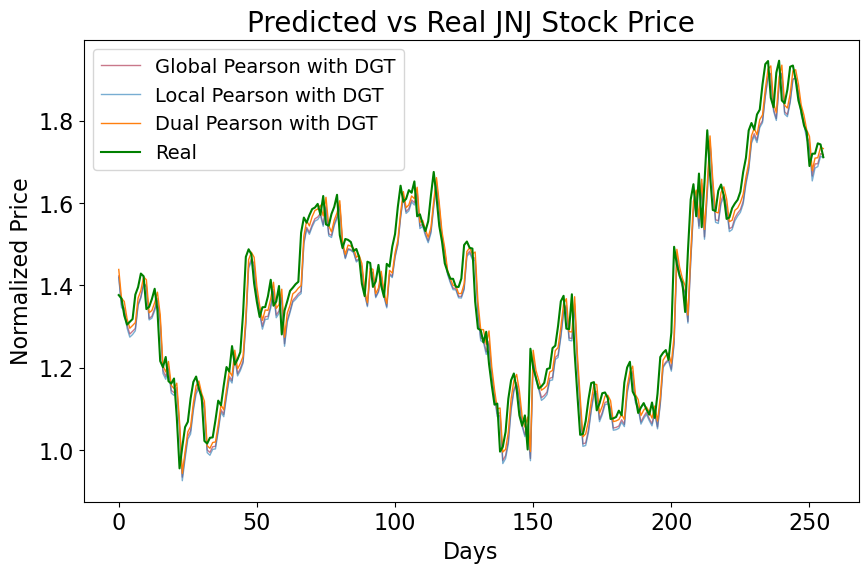

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, preds): # 235 is for Nvidia
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for (corr_name, corr_scope, gnn), label in zip(configs, labels):
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, corr_name, corr_scope, load_weights=True)
        if model is None:
            continue
        model.eval()
        with torch.no_grad():
            if label not in preds:
                y_hats = list(map(lambda snapshot: infer(model, snapshot).squeeze().cpu(), eval_dataset))
                preds[label] = y_hats
            else:
                y_hats = preds[label]
            ys = [snapshot.y.cpu() for snapshot in eval_dataset]
            targets = ys
            assert(len(y_hats) == len(ys))
            x = np.array(range(len(ys)))
            print(f'{label} Overall MAE: {mae(torch.stack(y_hats, dim=1), torch.stack(ys, dim=1))}')
            ys = np.array([y[stock_index] for y in ys])
            y_hats = np.array([y_hat[stock_index] for y_hat in y_hats])
            print(f'{label} Stock {stock_index} MAE: {mae(torch.tensor(y_hats), torch.tensor(ys))}')
            plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    return preds, targets

preds = {}
preds, targets = plot_regression([('pcc', 'global', DGT),
                            ('pcc', 'local', DGT),
                           ('pcc', 'dual', DGT)],
                           ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'], stock_name='NVDA', fig_name='sp500_regression_NVDA.png', preds=preds)
preds, targets = plot_regression([('pcc', 'global', DGT),
                            ('pcc', 'local', DGT),
                           ('pcc', 'dual', DGT)],
                           ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'], stock_name='JNJ', fig_name='sp500_regression_JNJ.png', preds=preds)

In [13]:
targets = torch.stack(targets, dim=1)
print(targets.shape)

torch.Size([472, 256])


In [14]:
maes = {}
for key, results in preds.items():
    results = torch.stack(results, dim=1)
    maes[key] = [mae(res, y) for res, y in zip(results, targets)]

print(maes.keys())

g_count = []
l_count = []
d_count = []

desired_count = []

for i, (g, l, d) in enumerate(zip(*maes.values())):
    if g < l and g < d and l < d:
        desired_count.append(i)
    if g < l and g < d:
        g_count.append(i)
    elif l < g and l < d:
        l_count.append(i)
    elif d < g and d < l:
        d_count.append(i)


print(f'Global < Local < Dual MAE is true for {len(desired_count)}, Global wins {len(g_count)}, Local wins {len(l_count)}, Dual wins {len(d_count)}')

print("Stocks when Global < Local < Dual MAE")
print([(stock_names[i]) for i in desired_count])
print("Stocks when Global wins")
print([(stock_names[i]) for i in g_count])
print("Stocks when Local wins")
print([(stock_names[i]) for i in l_count])
print("Stocks when Dual wins")
print([(stock_names[i]) for i in d_count])

dict_keys(['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'])
Global < Local < Dual MAE is true for 98, Global wins 117, Local wins 48, Dual wins 307
Stocks when Global < Local < Dual MAE
['AAL', 'ABT', 'ALB', 'AMCR', 'APA', 'APTV', 'ARE', 'BA', 'BALL', 'BAX', 'BBWI', 'BEN', 'BF-B', 'BIIB', 'BIO', 'BKR', 'BMY', 'BWA', 'BXP', 'C', 'CCI', 'CCL', 'CFG', 'CHTR', 'CLX', 'CPB', 'CPT', 'CTLT', 'CVS', 'CZR', 'D', 'DAL', 'DG', 'DIS', 'DOC', 'EL', 'ENPH', 'EPAM', 'EQR', 'ES', 'ESS', 'EW', 'EXPE', 'FIS', 'FMC', 'FRT', 'GE', 'GNRC', 'GPN', 'HAS', 'HOLX', 'HRL', 'INCY', 'INTC', 'IP', 'IVZ', 'KEY', 'KMX', 'LUV', 'LVS', 'MDT', 'MHK', 'MKTX', 'MMM', 'MOS', 'MTCH', 'MU', 'NCLH', 'NKE', 'NTRS', 'OXY', 'PARA', 'PAYC', 'PCG', 'PFE', 'PODD', 'RCL', 'SPG', 'SWK', 'SWKS', 'T', 'TAP', 'TDG', 'TFC', 'TFX', 'TGT', 'TPR', 'TSN', 'UAL', 'UDR', 'USB', 'VTR', 'VTRS', 'VZ', 'WDC', 'WYNN', 'ZBH', 'ZBRA']
Stocks when Global wins
['AAL', 'ABT', 'ALB', 'ALGN', 'AMCR', 'APA', 'APTV', 'ARE', 'A